In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
%reload_ext autoreload
%autoreload 2

# EDA

Set a predetermined seed so all our results can be replicated

In [3]:
RANDOM_SEED = 1337

### Data Source Description
- Raw data can be downloaded from: https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download
- Data was originally provided by IBM Sample Datasets with general information such as:
    - Customers who left within the last month – the column is called Churn
    - Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
    - Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
    - Demographic info about customers – gender, age range, and if they have partners and dependents 

In [103]:
full_data = pd.read_csv('Dataset/clean_data.csv',index_col='customerID')
churn = full_data['Churn'].copy()
full_data = full_data.drop('Churn',axis=1)

Data has 7043 observations and 19 features to work with. Our preprocessing script already handled and imputed all missingness.

In [20]:
full_data.shape

(7043, 19)

In [21]:
full_data.head(5)

,gender,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,1,NaN,DSL,No,Yes,No,No,No,No,Month-to-month,Electronic check,29.85,29.85,False,True,False,False,True
5575-GNVDE,Male,34,No,DSL,Yes,No,Yes,No,No,No,One year,Mailed check,56.95,1889.50,False,False,False,True,False
3668-QPYBK,Male,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Mailed check,53.85,108.15,False,False,False,True,True
7795-CFOCW,Male,45,NaN,DSL,Yes,No,Yes,Yes,No,No,One year,Bank transfer (automatic),42.30,1840.75,False,False,False,False,False
9237-HQITU,Female,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Electronic check,70.70,151.65,False,False,False,True,True


Column descriptions are scraped and cleaned from the kaggle website via beautifulsoup. It's been packaged in this repository for convenience's sake as a Json file. 

In [27]:
with open('col_desc.json','r') as f:
    col_desc = json.load(f)
    
#Shortened descriptions with elipses for plot titles
#Only retains first 20 characters of description then appends with elipses
short_col_desc = dict(zip(
    col_desc.keys(),
    map(lambda desc: 
        desc if len(desc)<20 else f'{desc[:27]}...', col_desc.values()
    )
))

# Preprocessing

In [72]:
#Get column names by dtype
num_cols = full_data.select_dtypes(np.number).columns
cat_cols = full_data.select_dtypes('object').columns
bin_cols = full_data.select_dtypes(bool).columns

# Target Column

We see that our target variable is quite imbalanced, hence we will have to take measures against this when training the models later on

<AxesSubplot: ylabel='Churn'>

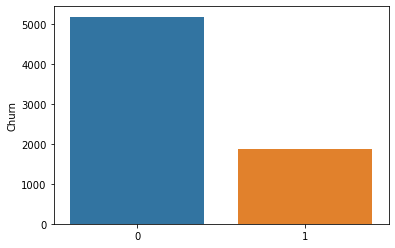

In [72]:
sns.barplot(x=churn.value_counts().index,y=churn.value_counts())

# Univariate Analysis

### Numerical Columns

In [25]:
from graph_utils import get_subplot_dim

We can make the following observations from the distribution of our three numerical columns:
- Both "Tenure" and "Monthly Charge" seems to have a roughly bimodal distribution, both with dips at value 40 
    - We can therefore roughly separate our customers between new and old at around the 40 months mark
    - We can also roughly separate our customers between budget and premium at around the $40 dollars mark
- Total Charges has a right skew distribution

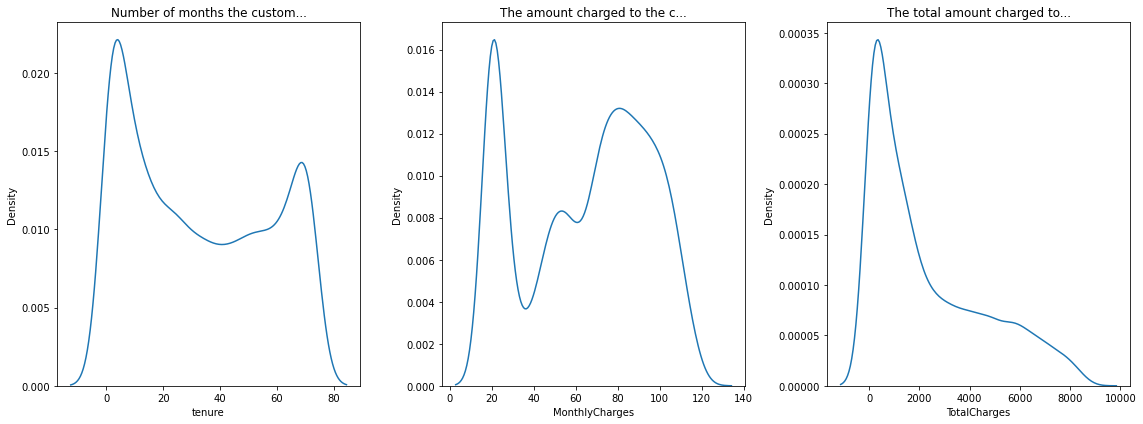

In [73]:
r, c = get_subplot_dim(len(num_cols))
fig, ax = plt.subplots(r,c,figsize=(16,6))
for col, subplot in zip(num_cols,ax.flatten()):
    sub_ax = sns.kdeplot(x=full_data[col],ax=subplot)
    sub_ax.set_title(short_col_desc[col])
plt.tight_layout()

### Categorical Columns

We can make the following interesting observations from the distribution of our categorical columns:
- We have a pretty good balance of genders
- Most customers are sign month-to-month contracts. Since the granularity of our data is month-to-month as well, it means any countermeasures we take against churn will need to be automated and react quickly to be of use. 

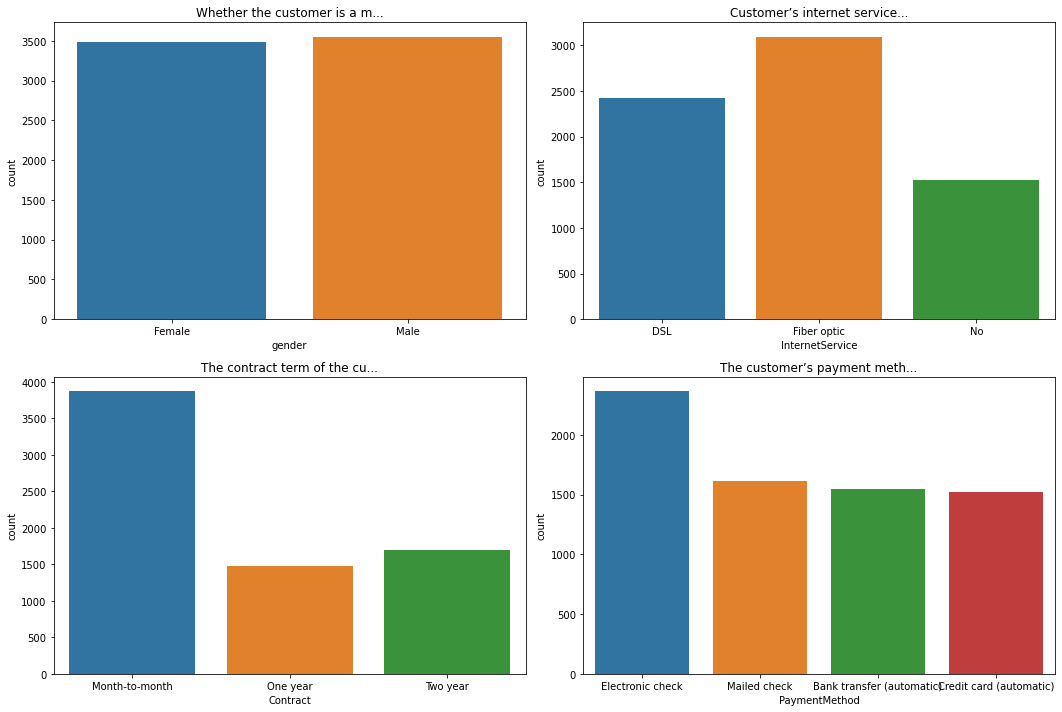

In [74]:
r, c = get_subplot_dim(len(cat_cols))
fig, ax = plt.subplots(r,c,figsize=(15,10))
for col, subplot in zip(cat_cols,ax.flatten()):
    sub_ax = sns.countplot(x=full_data[col],ax=subplot)
    sub_ax.set_title(short_col_desc[col])
plt.tight_layout()

### Binary Columns

It seems like most of our binary features are quite imbalanced.

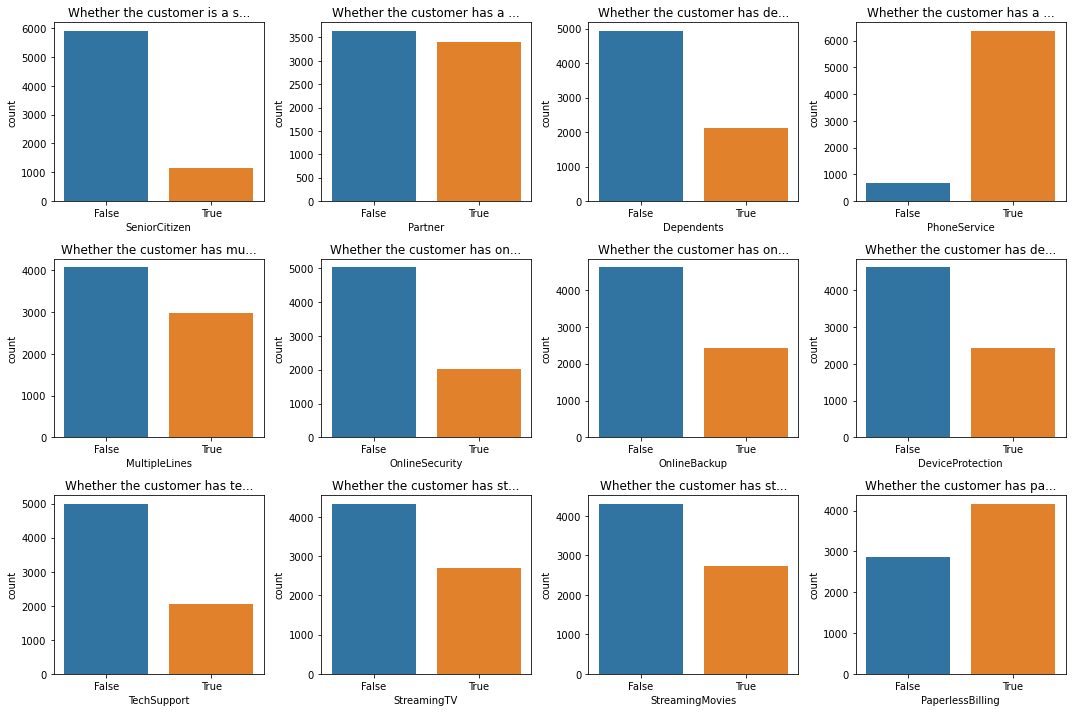

In [75]:
r, c = get_subplot_dim(len(bin_cols))
fig, ax = plt.subplots(r,c,figsize=(15,10))
for col, subplot in zip(bin_cols,ax.flatten()):
    sub_ax = sns.countplot(x=full_data[col],ax=subplot)
    sub_ax.set_title(short_col_desc[col])
plt.tight_layout()

# Multivariate Analysis

In [ ]:
# One-Hot encodes our categorical variables so we can create calculate corrs
cpu_readable_data = (
    full_data[num_cols]
    .join(full_data[bin_cols])
    .join(
        pd.get_dummies(full_data[cat_cols])
))

We can first look at how our features correlate with each other. From the heatmap below, we can make the following interesting observations:
 - It seems like long tenured customers are very unlikely to get month-to-month contracts. We should later examine whether year long contracts are cheaper. 
 - 

<AxesSubplot: >

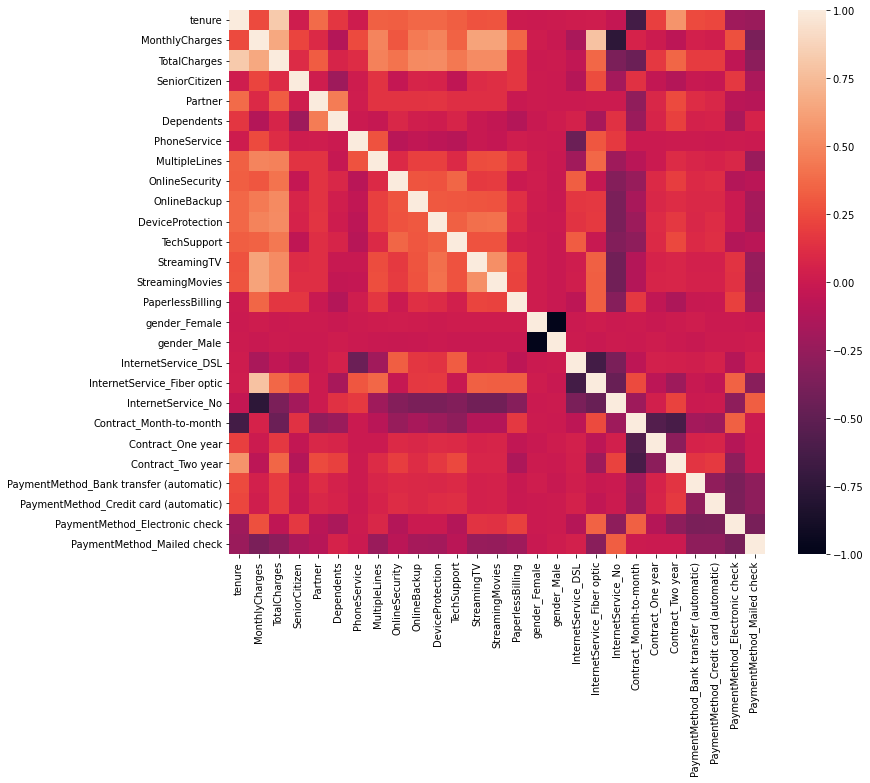

In [135]:
plt.figure(figsize=(12,10))
sns.heatmap(cpu_readable_data.corr())

We can calculate pearson's correlation coefficient for different values in our data with churn

In [82]:
churn_corrs = (
    cpu_readable_data.join(churn)
    .corr()
    .drop('Churn')['Churn'].sort_values()
)

From the correlation bar plot below we can see that:
 - As expected, the longer you have been with the company (tenure) the less likely you are to churn (negative correlation)
 - Contract type (Month-to-Month, One Year, Two year) also affects churn rates as expected where longer contracts mean less churn
 - Gender has no obvious effect on churn rates
 - Interestingly, customers who are more tech savvy (Uses Fiber Optics, Electronic Check, and Paperless Billing) are more likely to churn
    - However, those who enroll in automatic credit card payments are much less likely to churn, likely as these types of customers simply setup their accounts and don't pay much attention to their phone bills hence don't shop around as much
 - Senior Citizens are more likely to churn

<AxesSubplot: xlabel='Churn'>

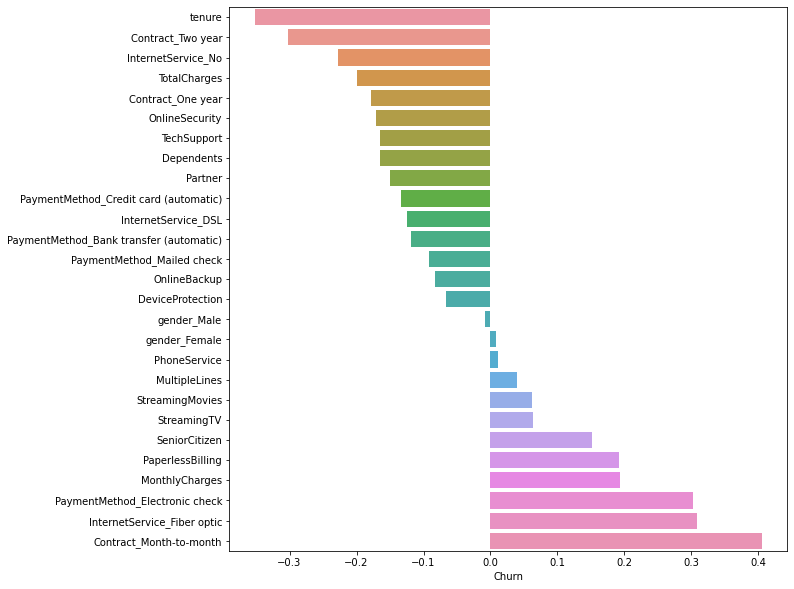

In [95]:
plt.figure(figsize=(10,10))
sns.barplot(x=churn_corrs,y=churn_corrs.index)

We can confirm some of our aforementioned observations with some distribution plots of numerical columns:
 - We see that a long tenure does indeed have a negative correlation with churn. 
    - However, the number of customers that churn after newly joining our services is roughly equal to those who stay
 -  Those offered cheap monthly charges are obviously less likely to churn, but many customers that churn never seemed to get a chance to be offered a cheap plan. Furthermore, plenty of customers with high monthly charges also stay. 
    -  Monthly charges therefore may not be the only cause for churn. 
    - We should therefore examine whether a budget plan (<$40) is only offered to certain types of customers (e.g only two-year contracts, only long tenure customers get budget plans)

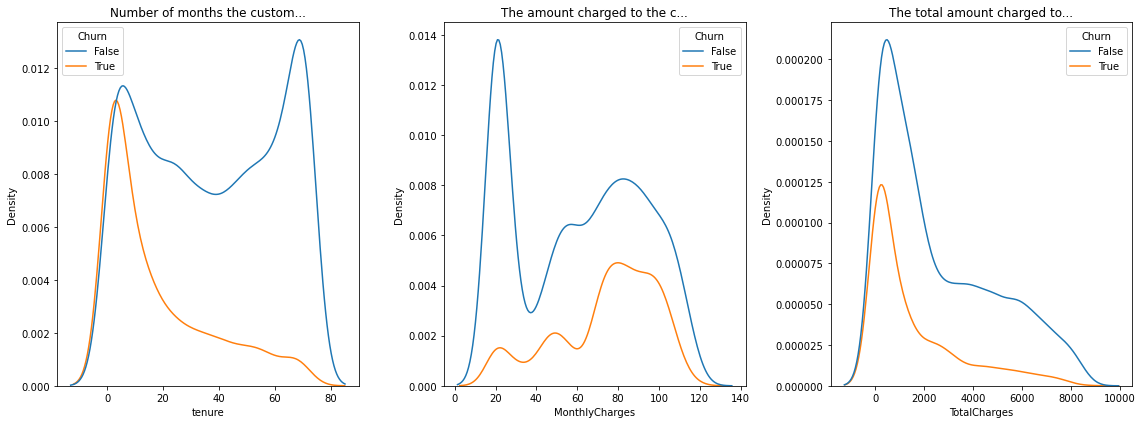

In [106]:
r, c = get_subplot_dim(len(num_cols))
fig, ax = plt.subplots(r,c,figsize=(16,6))
for col, subplot in zip(num_cols,ax.flatten()):
    sub_ax = sns.kdeplot(data=full_data[[col]].join(churn),x=col,hue='Churn',ax=subplot)
    sub_ax.set_title(short_col_desc[col])
plt.tight_layout()

From the graph below, it seems like you are just as likely to use a budget plan throughout your tenure

<AxesSubplot: xlabel='tenure', ylabel='Density'>

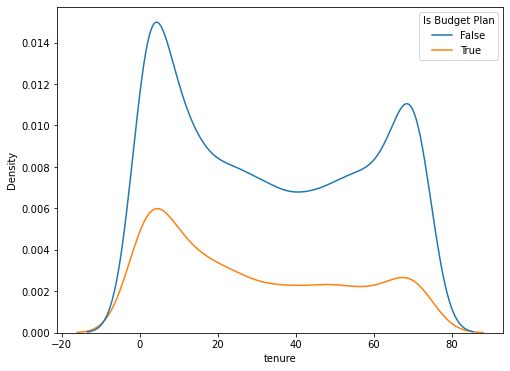

In [138]:
plt.figure(figsize=(8,6))
sns.kdeplot(
    data = (full_data[['tenure']]
        .join((full_data['MonthlyCharges']<=40)
              .rename('Is Budget Plan')
    )),
    x='tenure',
    hue='Is Budget Plan'
)

From the graph below, we see that plenty of Month-to-Month customers still are able to get budget plans, though yearly contract customers have a higher proportion of budget plan customers whereas the bulk of Month-to-Month customers have higher monthly charges. 

<AxesSubplot: xlabel='MonthlyCharges', ylabel='Density'>

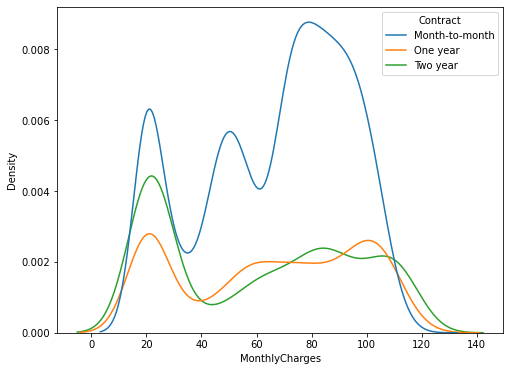

In [157]:
plt.figure(figsize=(8,6))
sns.kdeplot(
    data = full_data,
    x='MonthlyCharges',
    hue='Contract'
)

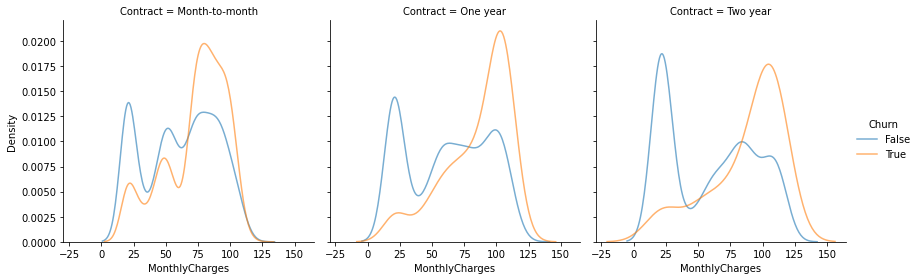

In [162]:
# %%capture --no-display <-command to silence seaborn warnings for cell
grid = sns.FacetGrid(full_data.join(churn), col='Contract', hue="Churn",height=4)
grid.map(sns.kdeplot, "MonthlyCharges", alpha=0.6)
grid.add_legend()